In [1]:
from numpy import *
def distEclud(vecA, vecB):  #计算欧氏距离
    return sqrt(sum(power(vecA - vecB, 2))) 

def distAbs(vecA,vecB):    #计算曼哈顿距离
    return sum(abs(vecA - vecB)) 

def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k,n)))   #创建一个k个质心，这些质心有n个feature
    for j in range(n):             #遍历创建k个质心的n个特征，其中特征的边界与原数据集保持一致
        minJ = min(dataSet[:,j]) 
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = mat(minJ + rangeJ * random.rand(k,1))
    return centroids   #返回质心数据集
    
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    '''k:聚类成k个分类,
    distMeas：可自定义距离类型，这里默认使用欧式距离，为K-means聚类，
    将其切换成曼哈顿距离（distAbs方法），即为K-medoids聚类
    createCent,创建k个质心的方法
    '''
    m = dataSet.shape[0]   #获取原数据集的列数
    clusterAssment = mat(zeros((m,2)))    #初始化m条数据的分类，距离矩阵                                    
    centroids = createCent(dataSet, k)   #创建质心数据集
    clusterChanged = True             #质心是否更新了，判断是否收敛
    while clusterChanged:               #当质心更新，不断迭代
        clusterChanged = False
        for i in range(m):      #遍历数据集
            minDist = inf;      #初始化距离
            minIndex = -1       #初始化分类
            for j in range(k):     #遍历k个质心，计算第索引为i的数据与索引为j的质心距离
                distJI = distMeas(centroids[j,:],dataSet[i,:])  
                if distJI < minDist:  #更新最小距离，更新第i条数据的属于的簇，与簇质心之间的距离
                    minDist = distJI
                    minIndex = j
            if clusterAssment[i,0] != minIndex: #如果存在一条数据的分类已经改变，说明还没有收敛
                clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2  #更新索引为i的数据的所属分类和距离
        for cent in range(k):     #重新计算质心
            ptsInClust = dataSet[nonzero(clusterAssment.A==cent)[0]]  #筛选出分类为cent的原数据
            centroids[cent,:] = mean(ptsInClust, axis=0) #重新计算分类为cent的质心
    return centroids, clusterAssment

def biKmeans(dataSet, k, distMeas=distEclud):
    '''
    k:聚类成k个分类,
    distMeas：可自定义距离类型，这里默认使用欧式距离，为K-means聚类，
    将其切换成曼哈顿距离（distAbs方法），即为K-medoids聚类
    
    二分K-均值(bisecting K-means)的算法。该算法首先将所有点作为一个簇，然后将该簇一分为二。
    之后选择其中一个 簇继续进行划分，选择哪一个簇进行划分取决于对其划分是否可以最大程度降低SSE的值。
    上述 基于SSE的划分过程不断重复，直到得到用户指定的簇数目为止。
    '''
    m = shape(dataSet)[0]     #获取原数据的列数
    clusterAssment = mat(zeros((m,2)))  #初始化m条数据的分类，距离矩阵
    centroid0 = mean(dataSet, axis=0)      #初始化一个质心
    centList =[centroid0]              #创建一个质心列表
    for j in range(m):                  #计算初始的质心与每个数据之间的距离
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):    #当质心列表小于分类数k时，不断迭代
        lowestSSE = inf        #初始化最优误差
        for i in range(len(centList)):   #遍历质心列表中的质心
            ptsInCurrCluster = dataSet[nonzero(clusterAssment.A==i)[0]]# 获取对应当前质心的数据集
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment.A!=i)[0],1]) #计算此质心对应的数据在原数据补集的误差之和
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)  #将当前质心的数据集进行切分
            sseSplit = sum(splitClustAss[:,1])#计算当前质心切分后的距离之和
            #print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:   #如果当前簇切分+其他未切分的簇的误差小于最优误差
                bestCentToSplit = i    #更新最优切分质心
                bestNewCents = centroidMat      #更新此次最优切分的质心
                bestClustAss = splitClustAss.copy()   #此次切分涉及的数据
                lowestSSE = sseSplit + sseNotSplit  #更新最优误差
        #print(bestNewCents)
        bestClustAss[nonzero(bestClustAss.A == 1)[0],0] =len(centList) #更新此次切分质心对应的数据切分后的分类
        bestClustAss[nonzero(bestClustAss.A == 0)[0],0] = bestCentToSplit #更新此次切分质心对应的数据切分后的分类
        centList[bestCentToSplit] = bestNewCents[0].tolist()[0]  #更新质心列表
        centList.append(bestNewCents[1].tolist()[0])        #更新质心列表
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#更新此次质心切分后的数据
    return array(centList), clusterAssment

class KMeans:
    def __init__(self,n_clusters):
        self.n=n_clusters
        self.centList=None
    def fit_predict(self,X):
        self.centList,clusterAssment=biKmeans(X,self.n)
    
        print(self.centList)
        self.pred=clusterAssment[:,0].flatten().A[0]
        return self.pred
    
    def fit(self,X):
        self.centList=biKmeans(X,self.n)[0]
        return self
    
    def predict(self,X):
        if self.centList is None:
            raise ChildProcessError('The model has not been trained yet, please call the fit method to train the model.')
        m,_=X.shape
        class_array=random.randn(m,self.n)
        for i in range(self.n):
            class_array[:,i]=np.sqrt(sum((X-self.centList[i])**2,axis=1))  #迭代更新距离矩阵
        pred=argmin(class_array,axis=1)
        return pred

#### 真实结果的可视化

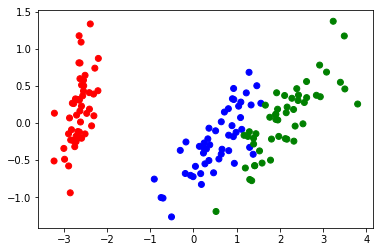

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

X,y=load_iris().data,load_iris().target
X=PCA(n_components=2).fit_transform(X)
color_dict={0:'red',1:'blue',2:'green'}
colors=[color_dict[i] for i in y] 
plt.figure()
plt.scatter(X[:,0],X[:,1],color=colors)

#### 使用自写的Kmean

[[ 0.75002011 -0.28422819]
 [-2.53737542  0.12775509]
 [ 2.37446608  0.26311694]]


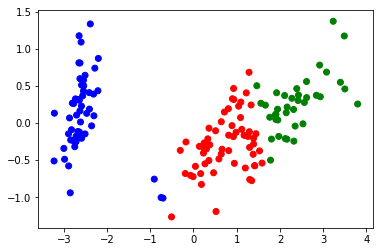

In [3]:
pred=KMeans(n_clusters=3).fit_predict(X)
color_dict={0:'red',1:'blue',2:'green'}
colors=[color_dict[i] for i in pred] 
plt.figure()
plt.scatter(X[:,0],X[:,1],color=colors)

#### 使用sklearn中的K-means进行聚类并可视化

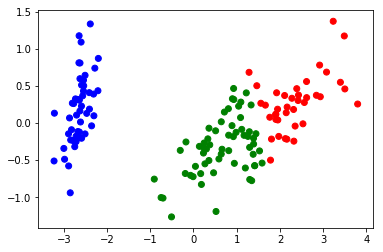

In [4]:
from sklearn.cluster import KMeans as sklearn_KMeans
pre=sklearn_KMeans(n_clusters=3).fit_predict(X)
color_dict={0:'red',1:'blue',2:'green'}
colors=[color_dict[i] for i in pre] 
plt.figure()
plt.scatter(X[:,0],X[:,1],color=colors)

#### 使用sklearn中的GMM模型进行聚类

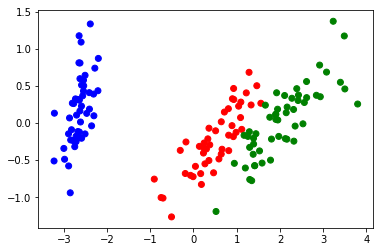

In [5]:
from sklearn.mixture import GaussianMixture
pre=GaussianMixture(n_components=3).fit(X).predict(X)
color_dict={0:'red',1:'blue',2:'green'}
colors=[color_dict[i] for i in pre] 
plt.figure()
plt.scatter(X[:,0],X[:,1],color=colors)